In [142]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt2
import random

In [143]:
window = 4
# shape[#number of feature, the window size, the output size]
shape = [2, window, 1]
# the number of neurons in each layer
neurons = [128,128,32,1]
# dropout rate
d=0.2

In [144]:
# normalize input data
def standard_scaler(stock_name, normalize=True):
    df = pd.read_excel('/Users/mrdoggie/Desktop/stock_with_sentiment.xlsx', sheetname=stock_name) # use this if sentiment info exists
#     df = pd.read_excel('/Users/mrdoggie/Desktop/stock_price.xlsx', sheetname=stock_name) # use this if sentiment info exists
#     df = pd.read_excel('stock_with_sentiment.xlsx', sheetname=stock_name) # use this if sentiment info exists
#     df = pd.read_excel('stock_price.xlsx', sheetname=stock_name) # use this if only stock info
    # if only stock info exists, normalize the stock info use min-max 
    if shape[0]==1 and normalize:
        min_max_scaler = prep.MinMaxScaler()
        df['price'] = min_max_scaler.fit_transform(df['price'].values.reshape(-1,1))
    # if price and stock info exists
    if shape[0]==2 and normalize:
        min_max_scaler = prep.MinMaxScaler()
        df['price'] = min_max_scaler.fit_transform(df['price'].values.reshape(-1,1))
        # first z-score normalization, then min-max normalization
        scaler = StandardScaler()
        scaler.fit(df['opinion'].values.reshape(-1,1))
        df['opinion'] = scaler.transform(df['opinion'].values.reshape(-1,1))
        df['opinion'] = min_max_scaler.fit_transform(df['opinion'].values.reshape(-1,1))
    return df

# reformat the input according to the window size
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    plt2.plot(data.T[-1], color='red', label='price')
#     plt2.plot(data.T[0][0:30], color='blue', label='opinion')
    plt2.legend(loc='upper left')
    plt2.show()
    
    sequence_length = seq_len + 1
    result = []
    # group according to the window size
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    # 10% as hold-out data
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    # generate train and test data
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [145]:
def build_model(layers, neurons, d):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        neurons[0],
        input_shape =(layers[1],layers[0]),
        return_sequences=True))
    model.add(Dropout(d))
    
    model.add(LSTM(
        neurons[1],
        input_shape=(layers[1],layers[0]),
        return_sequences=False))
    model.add(Dropout(d))

    model.add(Dense(neurons[2], activation='relu', kernel_initializer='uniform'))
    model.add(Dense(neurons[3], activation='linear', kernel_initializer='uniform'))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    model.summary()
    return model


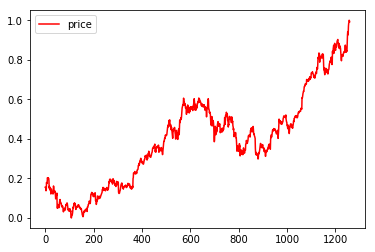

('X_train', (1130, 4, 2))
('y_train', (1130,))
('X_test', (125, 4, 2))
('y_test', (125,))


In [137]:
df = standard_scaler('AAPL', normalize=True)

X_train, y_train, X_test, y_test = preprocess_data(df, window)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

In [138]:
model = build_model(shape, neurons, d)

('Compilation Time : ', 0.04021096229553223)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 4, 128)            67072     
_________________________________________________________________
dropout_71 (Dropout)         (None, 4, 128)            0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_72 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

In [139]:
model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=200,
    validation_split=0,
    verbose=0)

In [140]:
pred = model.predict(X_test)
print pred

[[ 0.80605155]
 [ 0.8134023 ]
 [ 0.81356943]
 [ 0.80518818]
 [ 0.79663771]
 [ 0.78925055]
 [ 0.79811138]
 [ 0.80161685]
 [ 0.80298787]
 [ 0.80131853]
 [ 0.80084443]
 [ 0.80054343]
 [ 0.79806304]
 [ 0.7978738 ]
 [ 0.79946536]
 [ 0.80485761]
 [ 0.81088549]
 [ 0.80910176]
 [ 0.80748355]
 [ 0.7956273 ]
 [ 0.77546704]
 [ 0.75013554]
 [ 0.73932779]
 [ 0.73681271]
 [ 0.73217231]
 [ 0.73076576]
 [ 0.73343778]
 [ 0.74282557]
 [ 0.74098504]
 [ 0.74292827]
 [ 0.74031484]
 [ 0.73892671]
 [ 0.73506367]
 [ 0.73082316]
 [ 0.73196411]
 [ 0.72687805]
 [ 0.72665703]
 [ 0.72517288]
 [ 0.72640681]
 [ 0.72863817]
 [ 0.73595446]
 [ 0.74177539]
 [ 0.74838191]
 [ 0.75639963]
 [ 0.76599336]
 [ 0.77239853]
 [ 0.77609479]
 [ 0.77803922]
 [ 0.7794615 ]
 [ 0.77959973]
 [ 0.78636205]
 [ 0.79309392]
 [ 0.79092145]
 [ 0.78428292]
 [ 0.7738632 ]
 [ 0.77731454]
 [ 0.78814375]
 [ 0.80607271]
 [ 0.82518089]
 [ 0.82747161]
 [ 0.83883917]
 [ 0.84438372]
 [ 0.84321213]
 [ 0.84092975]
 [ 0.83817035]
 [ 0.85125768]
 [ 0.85708

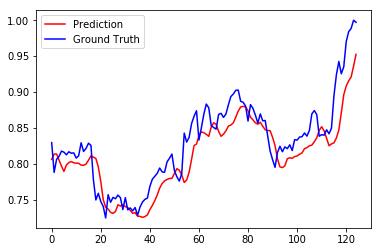

0.620967741935


In [141]:
plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

f_star=[]
f = []
v_star=[]
v=[]
# calculate the volatility and check whether the price is growing or decreasing
for i in range(pred.size-1):
    f_star.append((pred[i+1]-pred[i]>0))
    f.append((y_test[i+1]-y_test[i])>0)
counter = 0
# count the number of correct prediction
for i in range(len(f)):
    if f_star[i][0] == f[i]:
        counter += 1
acc = counter * 1.0 / (len(f))
print acc

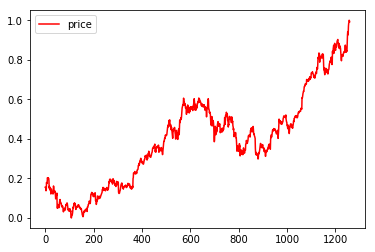

('Compilation Time : ', 0.0419011116027832)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_101 (LSTM)              (None, 3, 128)            67072     
_________________________________________________________________
dropout_101 (Dropout)        (None, 3, 128)            0         
_________________________________________________________________
lstm_102 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_102 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
__________________________

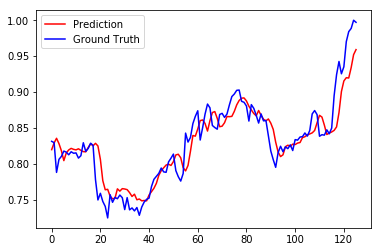

window: 3 accuracy: 0.464


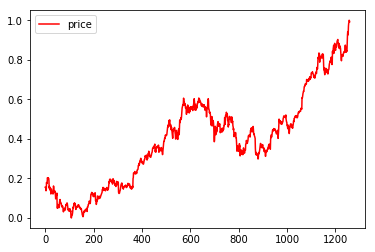

('Compilation Time : ', 0.03934597969055176)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_103 (LSTM)              (None, 4, 128)            67072     
_________________________________________________________________
dropout_103 (Dropout)        (None, 4, 128)            0         
_________________________________________________________________
lstm_104 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_104 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

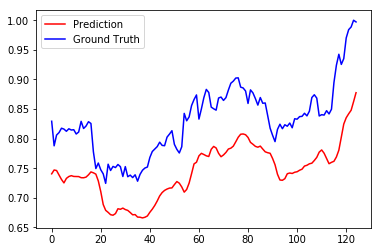

window: 4 accuracy: 0.612903225806


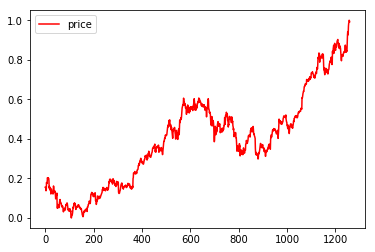

('Compilation Time : ', 0.03863406181335449)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_105 (LSTM)              (None, 5, 128)            67072     
_________________________________________________________________
dropout_105 (Dropout)        (None, 5, 128)            0         
_________________________________________________________________
lstm_106 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_106 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

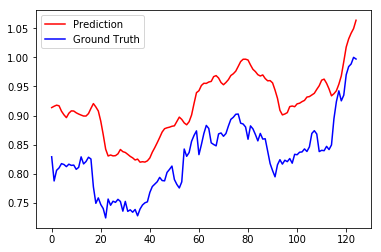

window: 5 accuracy: 0.532258064516


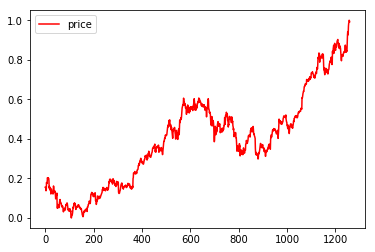

('Compilation Time : ', 0.04287600517272949)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_107 (LSTM)              (None, 6, 128)            67072     
_________________________________________________________________
dropout_107 (Dropout)        (None, 6, 128)            0         
_________________________________________________________________
lstm_108 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_108 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________

In [ ]:
# same code as above, iterate through different window size
for window in range(3,17):
    # window = 4
    shape = [2, window, 1]
    neurons = [128,128,32,1]
    d=0.2
    df = standard_scaler('AAPL', normalize=True)

    # X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
    X_train, y_train, X_test, y_test = preprocess_data(df, window)

    model = build_model(shape, neurons, d)

    model.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=200,
        validation_split=0,
        verbose=0)

    pred = model.predict(X_test)

    plt2.plot(pred, color='red', label='Prediction')
    plt2.plot(y_test, color='blue', label='Ground Truth')
    plt2.legend(loc='upper left')
    plt2.show()

    f_star=[]
    f = []
    v_star=[]
    v=[]
    for i in range(pred.size-1):
        f_star.append((pred[i+1]-pred[i]>0))
        f.append((y_test[i+1]-y_test[i])>0)
    counter = 0
    for i in range(len(f)):
        if f_star[i][0] == f[i]:
            counter += 1
    acc = counter * 1.0 / (len(f))
    print "window: "+str(window)+" accuracy: " + str(acc)
